In [1]:
# 加载必备库文件
import numpy as np

import mxnet as mx
from mxnet import nd
from mxnet import init
from mxnet import gluon
from mxnet import autograd

from mxnet.gluon import nn

In [2]:
# 为了便于参数导入，变量名最好和 gluoncv 的变量名相同
class BottleneckV1b(gluon.HybridBlock):
    """res 基本模块"""
    def __init__(self, channels, strides, isdownsample=False, **kwargs):
        super(BottleneckV1b, self).__init__(**kwargs)
        # 一个 bottleneck 内， 1*1 卷积 channel 扩大的倍数
        self.expansion = 4
        self.isdownsample = isdownsample
        self.strides = strides

        
        # bottletneck 内总是 1*1 conv -- 3*3 conv -- 1*1 conv
        self.conv1 = nn.Conv2D(channels=channels, kernel_size=(1,1), strides=(1,1),
                               padding=(0,0), groups=1, use_bias=False)
        self.bn1   = nn.BatchNorm() # use_global_stats=True 默认为 False
        self.relu  = nn.Activation('relu')
        
        self.conv2 = nn.Conv2D(channels=channels, kernel_size=3, strides=self.strides,
                               padding=(1,1), groups=1, use_bias=False)
        self.bn2   = nn.BatchNorm()
        
        self.conv3 = nn.Conv2D(channels=channels * self.expansion, kernel_size=(1,1), strides=(1,1),
                               padding=(0,0), groups=1, use_bias=False)
        self.bn3   = nn.BatchNorm()
        
        if self.isdownsample:
            self.downsample = nn.HybridSequential()
            self.downsample.add(nn.Conv2D(channels=channels * self.expansion, kernel_size=(1,1), strides=self.strides,
                                         padding=(0,0), groups=1, use_bias=False),
                                nn.BatchNorm())


    def hybrid_forward(self, F, x):
        residual = self.relu(self.bn1(self.conv1(x)))
        residual = self.relu(self.bn2(self.conv2(residual)))
        residual = self.bn3(self.conv3(residual))

        if self.isdownsample:
            x = self.downsample(x)

        x = x + residual
        out = self.relu(x)

        return out

In [3]:
class ResNet(gluon.HybridBlock):
    """ Pre-trained ResNetV1b Model, which produces the strides of 8
    featuremaps at conv5.

    Parameters
    ----------
    block_nums : list of int
        ResNet 每个 block 重复的次数
    channels : list of int
        每个 block 内卷积的 channel
    strides : list
        每个 block 的残差结构中 3*3 卷积的滑动步长 stride
    classes : int, default 1000
        目标类别的个数
    """
    # pylint: disable=unused-variable
    def __init__(self, block_nums, channels, strides, classes=1000, **kwargs):
        super(ResNet, self).__init__(**kwargs)

        self.features = nn.HybridSequential()
        self.features.add(nn.Conv2D(channels=64, kernel_size=(7,7), strides=(2,2),
                                    padding=(3,3), groups=1, use_bias=False))
        self.features.add(nn.BatchNorm())
        self.features.add(nn.Activation('relu'))
        self.features.add(nn.MaxPool2D(pool_size=(3,3), strides=(2,2), padding=(1,1)))
        
        # block_nums = [3, 4, 6, 3]
        # channels = [64, 128, 256, 512]
        # strides = [(1,1), (2,2), (2,2), (2,2)]
        for i in range(len(block_nums)):
            blk = nn.HybridSequential()
            for num in range(block_nums[i]) :
                if num == 0:
                    bottleneck = BottleneckV1b(channels[i], strides[i], isdownsample=True)
                else:
                    bottleneck = BottleneckV1b(channels[i], (1,1), isdownsample=False)
                blk.add(bottleneck)
            self.features.add(blk)

        self.avgpool = nn.GlobalAvgPool2D()
        self.out = nn.Dense(classes)

    def hybrid_forward(self, F, x):
        feature = self.features(x)
        out = self.avgpool(feature)
        out = self.out(out)
        return out

    
res18_blk_num  = [2, 2, 2,  2] # 不是 bottleneck
res50_blk_num  = [3, 4, 6,  3]
res101_blk_num = [3, 4, 23, 3]
res152_blk_num = [3, 8, 36, 3]

block_nums = [3, 4, 6, 3]
channels = [64, 128, 256, 512]
strides = [(1,1), (2,2), (2,2), (2,2)]

In [4]:
def compute_iou(bbox_a, bbox_b):
    """计算两组 bounding boxes 的 Intersection-Over-Union(IOU)

    Parameters
    ----------
    bbox_a : numpy.ndarray
        shape (M, 4) . bbox 格式 (xmin,ymin,xmax,ymax)
    bbox_b : numpy.ndarray
        shape (N, 4) . bbox 格式 (xmin,ymin,xmax,ymax)

    Returns
    -------
    二维数组 shape (M,N) ，其中任意一个元素 (i,j) 表示 bboxa[i] 和 bboxb[j] 的 IoU

    """
    
    if bbox_a.shape[1] < 4 or bbox_b.shape[1] < 4:
        raise IndexError("Bounding boxes axis 1 must have at least length 4")

    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    br = np.minimum(bbox_a[:, None, 2:4], bbox_b[:, 2:4])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:4] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:4] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)


# 依据 score 排序，从 score 最高第一个 box 开始，所有与该 box IOU 大于指定阈值的
# box 都会被删掉；同时把 box 加入到最终的队列中，并从原 list 中删除。
# 接着用队列中剩下的 score 最高的 box 去抑制队列中剩余的 box

# 可以先删掉 score 比较低的 box
def non_max_suppression(boxes, scores, threshold=0.7, topk=None):
    """执行 non-maximum suppression ，返回保留 boxes 的索引.
    boxes: [N, (y1, x1, y2, x2)]
    scores: 1-D array of box scores.
    threshold: Float. IoU 阈值，一般为 0.7
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)
    print("nms bbox shape", boxes.shape)
    print("nms scores shape", scores.shape)
    #print("nms bbox", boxes)
    #print("nms scores", scores)
    

    # scores 从大到小排序
    ixs = scores.argsort()[::-1]
    if topk:
        ixs = ixs[:topk]
    #print("nms ixs", ixs)

    pick = []
    while len(ixs) > 0:
        # 每次都选择队列中 score 最高的 box ，加入最终结果，并用他抑制队列中剩余的 box
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i][np.newaxis,:], boxes[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[1] + 1
        #print("nms remove_ixs", remove_ixs)
        # Remove indices of the picked and overlapped boxes.
        # 所有与 score 最高的 box IoU 大于阈值的 box 都从队列中移除
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    print("nms pick len ", len(pick))
    return np.array(pick, dtype=np.int32)

In [5]:
def center2corner(bbox):
    """ (x,y,w,h) --> (xmin,ymin,xmax,ymax) 
    shape: (N,4)"""
    shift = bbox[:,2:] / 2
    xymin = bbox[:,:2] - shift
    xymax = bbox[:,:2] + shift
    return np.concatenate((xymin,xymax), axis=-1)


def corner2center(bbox):
    """ (xmin,ymin,xmax,ymax) --> (x,y,w,h) 
    shape: (N,4) """
    xy = (bbox[:,2:] + bbox[:,:2]) / 2
    wh = bbox[:,2:] - bbox[:,:2]
    return np.concatenate((xy,wh), axis=-1)


def get_realbbox(bbox_pred, anchors, wh_max=4.42, std = (1,1)):
    """根据 anchor 得到预测边框的真实值
    bbox_pred, anchors 都是 numpy array 数据类型 (x, y, w, h) 形式，返回值同样，维度 (C,N,4)"""
    xy = bbox_pred[:,:,:2] * std[0] * anchors[:,:,2:] + anchors[:,:,:2]
    wh = anchors[:,:,2:] * np.minimum(np.exp(bbox_pred[:,:,2:] * std[1]), wh_max)
    return np.concatenate((xy,wh), axis=-1)


def bbox_clip_by_img(bbox, img):
    """bbox / 返回值 形式 (xmin,ymin,xmax,ymax) 
    维度 (N,4)"""
    imgsize = img[-2:]
    print(imgsize)
    bbox[:,:2] = np.maximum(bbox[:,:2], 0)
    bbox[:,:2] = np.minimum(bbox[:,:2], imgsize)
    bbox[:,2:] = np.minimum(bbox[:,2:], imgsize)
    bbox[:,2:] = np.maximum(bbox[:,2:], 0)
    return bbox

In [22]:
def anchor_gen(ratios, scales, width, height, stride):
    """生成 anchor
    return (x, y, w, h)"""
    anchor = []
    for s in scales:
        for r in ratios:
            # 使用 ROIAlign 不必在取整数
            w = s / np.sqrt(r)
            w = (w * 0.5)
            h = s * np.sqrt(r)
            h = (h * 0.5)
            anchor.append([-w, -h, w, h])
            
    anchor = np.array(anchor)

    x = range(width)
    y = range(height)
    x, y = np.meshgrid(x, y)
    
    offsets = np.concatenate((x[:,:,np.newaxis], y[:,:,np.newaxis], x[:,:,np.newaxis], y[:,:,np.newaxis]), axis = -1)
    offsets *= stride
    offsets = offsets.astype(np.float64)
    #print(offsets.shape)
    #print(offsets)
    # 中心点需要向右下角偏移 stride // 2
    offsets += stride / 2
    #print(offsets)
    
    anchor = anchor.reshape(1, -1, 4) + offsets.reshape(-1,1,4)
    anchor = anchor.reshape(-1, 4)
    
    anchor = bbox_clip_by_img(anchor, (width*stride, height*stride))
    anchor = corner2center(anchor)
    return anchor

ratios = [0.5, 1, 2]
scales = [32, 64, 128, 256, 512]

In [23]:
def remove_small_size(roi, score, cids=None, min_size = 16):
    # (xmin,ymin,xmax,ymax)
    width  = roi[:,2] - roi[:,0]
    height = roi[:,3] - roi[:,1]

    invalid = (width < min_size) + (height < min_size)
    invalidindex = np.where(invalid!=0)
    score = np.delete(score, invalidindex)
    if cids is not None:
        cids = np.delete(cids, invalidindex)
    roi = np.delete(roi, invalidindex, axis=0)
    return cids, score, roi


def proposal(anchor, score, bbox_pred, pre_nms, post_nms, img, nms_threshold=0.3):
    """
    anchor , bbox_pred 都是 (x,y,w,h) 格式
    返回值是 (xmin, ymin, xmax, ymax)
    """
    #pre_nms  = 6000
    #post_nms = 300
    #min_size = 60

    # 根据 anchor 得到 Bbox 的真实大小 。 入参/返回值： (x,y,w,h)
    roi = get_realbbox(bbox_pred[None,:], anchor[None,:])
    print("roi shape", roi.shape)

    # roi 不能超过图像的边界。入参/返回值： (xmin,ymin,xmax,ymax)
    roi = bbox_clip_by_img(center2corner(np.squeeze(roi)), img)

    # 移除小于 min_size 的 roi  参/返回值： (xmin,ymin,xmax,ymax)
    _, score, roi = remove_small_size(roi, score)
    
    print("roi--after remove small size", roi.shape)
    print("scores--after remove small size", score.shape)

    # Non-maximum suppression 入参是 (xmin, ymin, xmax, ymax)
    keepindex = non_max_suppression(roi, score, nms_threshold, pre_nms)
    
    print("proposal keepindex shape", keepindex.shape)

    # 仅仅保留 post_nms 个数的 boxes
    if post_nms:
        keepindex = keepindex[:post_nms]

    print("proposal keepindex shape--after rpn nms", keepindex.shape)

    rpn_scores = score[keepindex]
    rpn_bbox = roi[keepindex,:]

    return rpn_scores, rpn_bbox


In [24]:
def maxoutput(scores, bbox):
    """每个框只选取概率最大的类别输出
    scores (M,N) . M 是个数， N 是类别数
    bbox   (M,N,4)
    """
    print("socres.shape", scores.shape)
    print("bbox.shape", bbox.shape)
    
    scores = np.where(scores > 0.01, scores, 0)

    index = scores.argsort(axis=-1)
    index = index[:,::-1] # 逆序
    cid  = index[:,0].astype(np.int32)
    #print(cids)

    score = []
    # len(index) == M
    for i in range(len(index)):
        score.append(scores[i,cid[i]])
        if i == 0:
            box = bbox[i,cid[i],:]
        else:
            box = np.row_stack([box, bbox[i,cid[i],:]])

    score = np.array(score)
    return cid, score, box

def cleanoutput(cid, score, box, threhold=0.5):
    """去除概率小于阈值的预测"""

    # cid   类别标号  (M,) -- 0,1,2,3...79
    # score 类别概率  (M,) -- 0.98,0.73,....
    # box   框       (M,4) -- (x1,y1,x2,y2)

    # 删除概率小于阈值的方框
    remove_ixs = np.where(score < threhold)[0]
    #print("score", score)
    #print("remove_ixs", remove_ixs)
    print("box.shape", box.shape)
    clean_cid   = np.delete(cid, remove_ixs)
    clean_score = np.delete(score, remove_ixs, axis=0)
    clean_box   = np.delete(box, remove_ixs, axis=0)
    
    return clean_cid, clean_score, clean_box


def  classify_ouput(cids, scores, bbox):
    """将输出按照类别分类，便于分类别进行 NMS
    data : numpy array
    
    输出 list 
    """
    # 按照类别进行排序
    index = cids.argsort()
    cids = cids[index]
    scores = scores[index]
    bbox = bbox[index,:]
    
    split_index = []
    clas = cids[0]
    index = 0
    for i in range(1, len(cids)):
        index += 1
        if clas != cids[i]:
            split_index.append(index)
            clas = cids[i]
            
    data = np.column_stack((cids, scores, bbox))

    return np.split(data, split_index)


def perclassnms(data, threshold=0.5):
    """将输出结果分类别进行 NMS ，输出处理后的结果"""
    
    output = []
    for i in range(len(data)):
        bbox = data[i][:,2:]
        score = data[i][:,1]
        keepindex = non_max_suppression(bbox, score, threshold)
        if i == 0:
            output = data[i][keepindex,:]
        else:
            output = np.row_stack([output,data[i][keepindex,:]])

    return output

In [30]:
imgsize = [800,800]
class FasterRcnn(gluon.HybridBlock):
    """res50 为 bone 的 faster r-cnn"""
    def __init__(self, class_num=80, **kwargs):
        super(FasterRcnn, self).__init__(**kwargs)
        self.img = imgsize
        
        # resnet50
        self.block_nums = [3, 4, 6, 3]
        self.channels = [64, 128, 256, 512]
        self.strides = [(1,1), (2,2), (2,2), (2,2)]
        
        # gluoncv 中使用了 15 个 anchor
        self.ratios = [0.5, 1, 2]
        self.scales = [32, 64, 128, 256, 512]
        self.anchor_depth = len(self.ratios) * len(self.scales)
        self.rpn_channels = 1024
        self.rpn_nms_threshold = 0.7
        self.roi_size = (14, 14)
        self.pre_nms = 6000
        self.post_nms = 300
        self.stride = 16

        self.class_num = class_num 
        self.socre_thread = 0.01

        # 网络的 bone
        bone = ResNet(self.block_nums, self.channels, self.strides)
        self.features = bone.features[:7]
        self.top_features = bone.features[7:8]

        # 输出预测网络
        self.global_avg_pool = nn.GlobalAvgPool2D()
        self.class_predictor = nn.Dense(self.class_num + 1)
        self.box_predictor = nn.Dense(self.class_num * 4)

        # RPN 网络
        self.rpn = nn.HybridSequential()
        self.rpn.add(nn.Conv2D(self.rpn_channels, 3, 1, 1))
        self.rpn.add(nn.Activation('relu'))
        # 使用了 sigmoid 而不是 softmax，减少通道的个数
        self.rpn_score = nn.Conv2D(self.anchor_depth, 1, 1, 0)
        self.rpn_loc = nn.Conv2D(self.anchor_depth * 4, 1, 1, 0)

        
    def hybrid_forward(self, F, x):
        # 提取特征
        feat   = self.features(x)
        print("x",x.shape)
        print("feat",feat.shape)
        width  = feat.shape[2]
        height = feat.shape[3]

        # RPN
        rpn = self.rpn(feat)
        print("rpn conv3*3 shape", rpn.shape)
        raw_rpn_score = self.rpn_score(rpn).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 1))
        rpn_score = nd.sigmoid(raw_rpn_score)
        # rpn_box_pred -- (x,y,w,h)
        rpn_box_pred = self.rpn_loc(rpn).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 4))
        print("rpn_score shape", rpn_score.shape)
        print("rpn_box_pred shape", rpn_box_pred.shape)
        # 生成 anchor (x,y,w,h)
        anchor = anchor_gen(self.ratios, self.scales, width, height, self.stride)
        print("anchor", anchor.shape)
        # 入参/返回值全部是 numpy.array 。
        # 入参 rpn_box_pred/anchor -- (x,y,w,h); 返回值 rpn_box -- (xmin,ymin,xmax,ymax)
        rpn_score, rpn_box = proposal(anchor, np.squeeze(rpn_score.asnumpy()), np.squeeze(rpn_box_pred.asnumpy()), 
                                      self.pre_nms, self.post_nms, self.img, self.rpn_nms_threshold)
        print("proposal--rpn_score shape", rpn_score.shape)
        print("proposal--rpn_box shape", rpn_box.shape)

        # roi 开始增加 batchid 0
        rpn_box = rpn_box.reshape((-1, 4))
        # tmp 作为返回值，画图检查 proposal 建议的前景框怎么样
        plt_rpn_box = rpn_box
        plt_rpn_score = rpn_score
        roi_batchid = nd.zeros((min(rpn_box.shape[0], self.post_nms), 1))
        rpn_box = nd.array(rpn_box)
        rpn_roi = nd.concat(*[roi_batchid, rpn_box], dim=-1)        
        # ROIPolling 入参 (xmin,ymin,xmax,ymax)
        # 拿到这里的入参 rpn_roi 不需要除以 stride ，因为入参中有 stride 参数 TODO
        #pooled_feat = nd.ROIPooling(feat, rpn_roi, self.roi_size, 1. / self.stride)
        pooled_feat = nd.contrib.ROIAlign(feat, rpn_roi, self.roi_size, 1. / self.stride)
        print("pooled_feat shape", pooled_feat.shape)

        # RCNN prediction
        top_feat = self.top_features(pooled_feat)
        avg_feat = self.global_avg_pool(top_feat)
        cls_pred = self.class_predictor(avg_feat)
        box_pred = self.box_predictor(avg_feat)

        cls_pred = cls_pred.reshape((self.post_nms, self.class_num + 1))
        # 0 是背景的概率，只需要前景的即可 ; 不是说好了要使用 sigmoid 吗？ TODO
        cls_pred = nd.softmax(cls_pred, axis=-1)[:,1:].asnumpy()
        print("cls_pred shape", cls_pred.shape)
        #box_pred = box_pred.reshape((self.post_nms, self.class_num, 4)).transpose((1,0,2))
        box_pred = box_pred.reshape((self.post_nms, self.class_num, 4)).asnumpy() # (x,y,w,h)
        print("box_pred", box_pred.shape)
        
        # 每个 box 只输出类别概率最大的
        cids, scores, box_pred = maxoutput(cls_pred, box_pred)
        print("cids shape", cids.shape)
        print("scores shape", scores.shape)
        print("box_pred", box_pred.shape)
        
        # 将 rpn_box 从 (xmin,ymin,xmax,ymax) 转换到 (x,y,w,h)
        rpn_box = corner2center(rpn_box.reshape(-1,4).asnumpy())
        print("rpn_box", rpn_box)
        print("box_pred", box_pred)
        # 入参/返回值是 (x,y,w,h) 格式 ，且返回值维度 (C,N,4)
        bbox = get_realbbox(box_pred.reshape(1,-1,4), rpn_box.reshape(1,-1,4), wh_max=4.42, std = (0.1,0.2))
        print("bbox", bbox.shape)
        cids, scores, bbox = cleanoutput(cids, scores, np.squeeze(bbox))
        # 入参/返回值都是 (xmin,ymin,xmax,ymax) 格式
        bbox = bbox_clip_by_img(center2corner(bbox.reshape(-1,4)), img=imgsize)
        #bbox = bbox.transpose((1,0,2))
        # 入参/返回值都是 (xmin,ymin,xmax,ymax) 格式
        cids, scores, bbox = remove_small_size(bbox, scores, cids, 1)
        print("bbox", bbox.shape)        

        # 输出按照类别分组
        data = classify_ouput(cids, scores, bbox)
        #print(data)
        plotoutput = perclassnms(data, 0.1)
        #print(plotoutput)

        bounding_boxs = plotoutput[:,2:]
        scores = plotoutput[:,1]
        class_IDs = plotoutput[:,0]
        print("class_IDs", class_IDs)
        print("scores", scores)
        print("bbox", bounding_boxs)

        return bounding_boxs, scores, class_IDs, plt_rpn_box, plt_rpn_score


In [31]:
net = FasterRcnn()

# 加载参数
net.features.load_parameters("features.params")
net.top_features.load_parameters("topfeatures.params")
#net.global_avg_pool.load_parameters("global_avg_pool.params")
net.class_predictor.load_parameters("class_predictor.params")
net.box_predictor.load_parameters("box_predictor.params")
net.rpn.load_parameters("rpn_conv1.params")
net.rpn_score.load_parameters("rpn_score.params")
net.rpn_loc.load_parameters("rpn_loc.params")

In [32]:
# coco 80 个类
classes_name = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
                'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [33]:
def preprocessing_img(imgname, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """图像 nominalize 
    测试的时候，transform 不需要额外的处理，只需要归一化以及将 BCWH -> 

    Parameters
    ----------
    imgs : string 
        待处理的图像名字
    mean : iterable of float
        imagenet mean
    std : iterable of float
        imagenet std

    Returns
    -------
    网络的输入和 resize 后的图像

    """
    
    img = mx.image.imread(imgname)

    # 可能只能在 800*600 时 work
    img = mx.image.imresize(img, imgsize[0], imgsize[1])
    orig_img = img.asnumpy().astype('uint8')
    img = mx.nd.image.to_tensor(img)
    img = mx.nd.image.normalize(img, mean=mean, std=std)
    print(img.shape)
    # img.expand_dims(0) 由 CHW -> BCHW
    return img.expand_dims(0), orig_img

In [46]:
imgname = '1.jpg'
imgname = '2.jpg'
imgname = 'eagle.jpg'
imgname = 'person.jpg'
imgname = 'biking.jpg'
imgname = '3.jpg'
imgname = 'giraffe.jpg'
imgname = 'horses.jpg'
imgname = 'dog.jpg'

x, img = preprocessing_img(imgname)
y = net(x)

(3, 800, 800)
x (1, 3, 800, 800)
feat (1, 1024, 50, 50)
rpn conv3*3 shape (1, 1024, 50, 50)
rpn_score shape (1, 37500, 1)
rpn_box_pred shape (1, 37500, 4)
(800, 800)
anchor (37500, 4)
roi shape (1, 37500, 4)
[800, 800]
roi--after remove small size (37424, 4)
scores--after remove small size (37424,)
nms bbox shape (37424, 4)
nms scores shape (37424,)
nms pick len  2280
proposal keepindex shape (2280,)
proposal keepindex shape--after rpn nms (300,)
proposal--rpn_score shape (300,)
proposal--rpn_box shape (300, 4)
pooled_feat shape (300, 1024, 14, 14)
cls_pred shape (300, 80)
box_pred (300, 80, 4)
socres.shape (300, 80)
bbox.shape (300, 80, 4)
cids shape (300,)
scores shape (300,)
box_pred (300, 4)
rpn_box [[ 600.69232178  171.75946045   32.35632324   54.71650696]
 [ 586.26037598  169.90765381   28.81365967   53.96861267]
 [ 614.56549072  173.83210754   30.43737793   56.84350586]
 ..., 
 [ 664.57531738  315.86044312   85.14447021  105.02526855]
 [ 312.48568726  345.1293335    70.51342773 

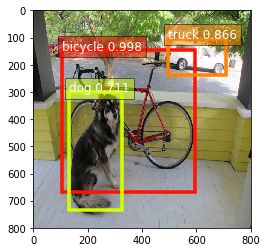

In [47]:
%matplotlib inline

from gluoncv import utils
from matplotlib import pyplot as plt

bounding_boxs, scores, class_IDs, plt_rpn_box, plt_rpn_score = y

ax = utils.viz.plot_bbox(img, bounding_boxs, scores,
                         class_IDs, class_names=classes_name)
plt.show()

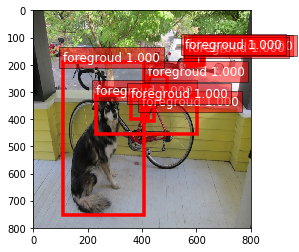

In [48]:
# 查看 proposal 的情况
num = 10
rpn_cls_id = np.zeros(num)
classes_name = ['foregroud', 'backgroud']
ax = utils.viz.plot_bbox(img, plt_rpn_box[:num], plt_rpn_score[:num],
                         rpn_cls_id[:num], class_names=classes_name)
plt.show()

In [ ]:
# 如果是初次运行，需要先运行来保存模型参数
from gluoncv import model_zoo

net = model_zoo.get_model('faster_rcnn_resnet50_v1b_coco', pretrained=True)

net.features.save_parameters("features.params")
net.top_features.save_parameters("topfeatures.params")
#net.global_avg_pool.save_parameters("global_avg_pool.params")
net.class_predictor.save_parameters("class_predictor.params")
net.box_predictor.save_parameters("box_predictor.params")
net.rpn.conv1.save_parameters("rpn_conv1.params")
net.rpn.score.save_parameters("rpn_score.params")
net.rpn.loc.save_parameters("rpn_loc.params")

In [ ]:
# 网络保存，TODO
net.hybridize()
net.forward(x)
net.export("fasterrcnn")